# Introduction to ERDDAP and Matchup satellite data to animal tracks

## Overview
> History | Updated Feb 2025  

In this tutorial you will learn about ERDDAP data server, access satellite data from ERDDAP server, and match the data with an animal telemetry track.

## What is ERDDAP
For many users, obtaining the ocean satellite data they need requires downloading data from several data providers, each with its own file formats, download protocols, subset abilities, and preview abilities. 

The goal behind ERDDAP is to make it easier for you to get scientific data. To accomplish that goal, ERDDAP acts as a middleman, selectively channeling datasets from remote and local data sources to a single data portal. With ERDDAP as the single-source portal, you have access to a simple, consistent way to download subsets of gridded and tabular scientific datasets in common file formats, with options and make graphs and maps.

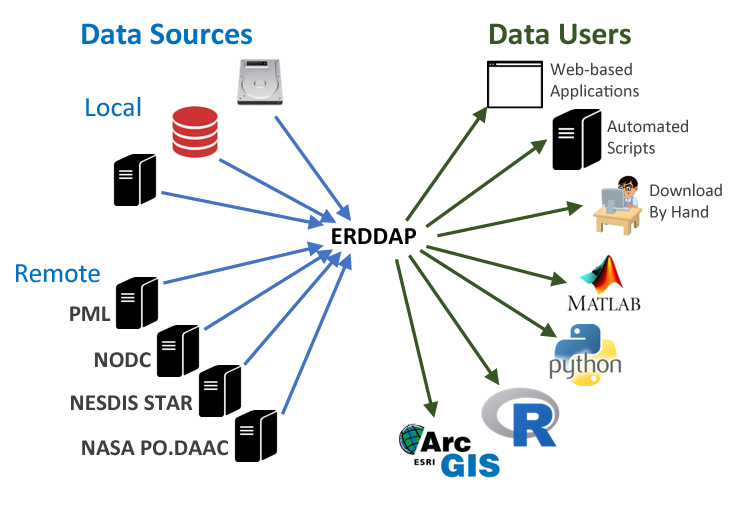

__Features of ERDDAP:__  

* Data in the common file format of your choice. ERDDAP offers all data as .html table, ESRI .asc and .csv, Google Earth .kml, OPeNDAP binary, .mat, .nc, ODV .txt, .csv, .tsv, .json, and .xhtml
* ERDDAP can also return a .png or .pdf image with a customized graph or map
* Standardized dates/times ("seconds since 1970-01-01T00:00:00Z" in UTC)
* A graphical interface for humans with browsers
* RESTful web services for machine-to-machine data exchange and downloading data directly into your software applications (e.g.Matlab, R, Python...) and even into web pages.


## Understanding the ERDDAP URL
Download requests to ERDDAP are completely defined within a URL, allowing:

* machine-to-machine data exchange,
* bringing data directly into analysis tools,
* and the use ERDDAP as a back end to drive customized online interfaces.

For example, here is the ERDDAP URLs of the monthly chlorophyll-a from European Space Agency's OC-CCI product:
`https://oceanwatch.pifsc.noaa.gov/erddap/griddap/esa-cci-chla-monthly-v6-0.csv?chlor_a[(2023-03-01)][(89.9792):(-89.9792)][(0.02083):(359.9792)]`  

__We can deconstruct the URL into its component parts:__   

| Name | Value | Description | 
| ---: |    :---- | :--- | 
| ERDDAP base URL | __https://oceanwatch.pifsc.noaa.gov/erddap/griddap/__ | Web location of ERDDAP server|
| Dataset ID | __esa-cci-chla-monthly-v6-0__ | Unique dataset ID |
| Download file | __.csv__ | Data file to download (CSV is this case) |
| Query indicator | __?__ | Mark start of data query |
| Variable | __chlor_a__ | ERDDAP variable to download |
| Time range | __[(2023-02-15):1:(2023-03-01)]__ | Temporal date range to download |
| Latitude range | __[(89.9792):(-89.9792)]__ | Latitude range to download |
| Longitude range | __[(0.02083):(359.9792)]__ | Longitude range to download |  


By reading the URL, you get an idea of the data to be accessed, and you can modify the data request by simply modifying the URL.

## List of ERDDAP servers

ERDDAP has been installed by over 100 organizations worldwide.

__CoastWatch__  
* CoastWatch West Coast Node https://coastwatch.pfeg.noaa.gov/erddap/
* CoastWatch PolarWatch Node https://polarwatch.noaa.gov/erddap/index.html
* CoastWatch Central Pacific Node https://oceanwatch.pifsc.noaa.gov/erddap/
* CoastWatch Gulf of Mexico Node https://cwcgom.aoml.noaa.gov/erddap/
* CoastWatch Great Lakes Node https://coastwatch.glerl.noaa.gov/erddap/
* CoastWatch Central https://coastwatch.noaa.gov/erddap/

__Other organizations__  
A more complete list is available at the following link: https://coastwatch.pfeg.noaa.gov/erddap/download/setup.html#organizations

__Tutorials on how to use ERDDAP servers__  
CoastWatch Tutorials- ERDDAP basics: https://github.com/coastwatch-training/CoastWatch-Tutorials/tree/main/ERDDAP-basics

## Matchup satellite data to animal tracks

In this exercise you will extract satellite data around a set of points defined by longitude, latitude, and time coordinates, like that produced by an animal telemetry tag, and ship track, or a glider tract.

Please note that there may be more efficient ways, more Pythonic ways, to accomplish the tasks in this tutorial. The tutorial was developed to be easier to follow for less experienced users of Python.

### The exercise demonstrates the following techniques:

* Loading data from a tab- or comma-separated file
* Plotting the latitude/longitude points onto a map 
* Extracting satellite data along a track
* Building an ERDDAP data-request URL
* Saving results as a CSV file
* Plotting the satellite data onto a map  

### Datasets used:
- Chlorophyll a concentration from the European Space Agency's Ocean Colour Climate Change Initiative Monthly dataset v6.0
- A loggerhead turtle telemetry track that has been subsample to reduce the data requests needed for this tutorial from over 1200 to 25. The turtle was raised in captivity in Japan, then tagged and released on 05/04/2005 in the Central Pacific. Its tag transmitted for over 3 years and went all the way to the Southern tip of Baja California. The track data can be downloaded from `data` folder in this project folder.

### Python packages used:
- pandas (reading and analyzing data)  
- numpy  (data analysis, manipulation)
- xarray (multi-dimensional data analysis, manipulation)
- matplotlib (mapping)
- cartopy (mapping)
- datetime (date manipulation)

## Import the required Python modules

In [1]:
from IPython.display import clear_output
import pandas as pd
import numpy as np
import os
import warnings
from urllib.parse import quote
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import matplotlib.pyplot as plt
import xarray as xr
warnings.filterwarnings('ignore')

## Load the track data into a Pandas data frame
Below, the track data will load using the Pandas "read_csv" method. 
* Then use the ".head()" method to view the column names and the first few rows of data. 


In [2]:
track_path = os.path.join('.',
                          'data',
                          '25317_05_subsampled.dat')
df = pd.read_csv(track_path)
print(df.head(2))
print(' ')
print('Data types for each column')
print(df.dtypes)
print(' ')
print('Spatial corrdinate ranges')
print('latitude range', round(df.mean_lat.min(), 2), round(df.mean_lat.max(), 2))
print('longitude range', round(df.mean_lon.min(), 2), round(df.mean_lon.max(), 2))

     mean_lon   mean_lat  year  month  day
0  176.619433  32.678728  2005      5    4
1  175.860895  35.057734  2005      6   23
 
Data types for each column
mean_lon    float64
mean_lat    float64
year          int64
month         int64
day           int64
dtype: object
 
Spatial corrdinate ranges
latitude range 23.72 41.77
longitude range 175.86 248.57


## Plot the track on a map

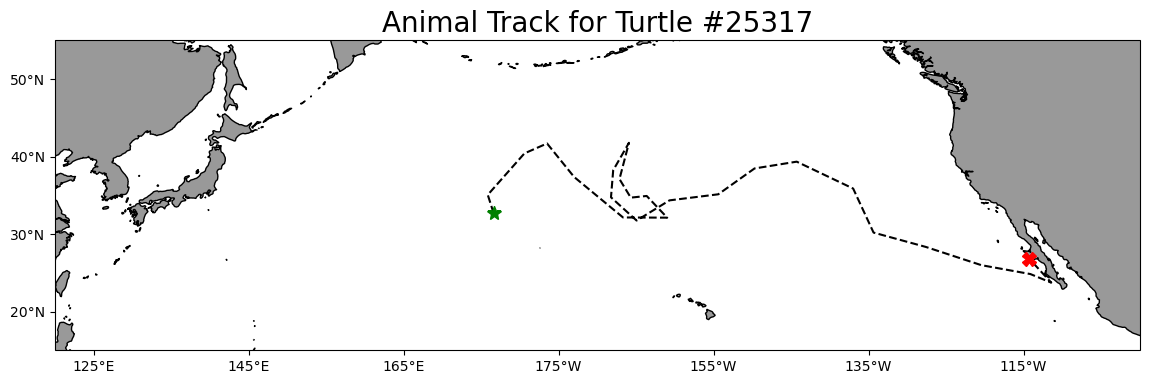

In [101]:
plt.figure(figsize=(14, 10))

# Label axes of a Plate Carree projection with a central longitude of 180:
ax1 = plt.subplot(211, projection=ccrs.PlateCarree(central_longitude=180))

# Use the lon and lat ranges to set the extent of the map
# the 120, 260 lon range will show the whole Pacific
# the 15, 55 lat range with capture the range of the data
ax1.set_extent([120, 260, 15, 55], ccrs.PlateCarree())

# Set the tick marks to be slightly inside the map extents
ax1.set_xticks(range(125, 255, 20), crs=ccrs.PlateCarree())
ax1.set_yticks(range(20, 60, 10), crs=ccrs.PlateCarree())

# Add feature to the map
ax1.add_feature(cfeature.LAND, facecolor='0.6')
ax1.coastlines()

# Format the lat and lon axis labels
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax1.xaxis.set_major_formatter(lon_formatter)
ax1.yaxis.set_major_formatter(lat_formatter)

# Bring the lon and lat data into a numpy array 
x, y = df.mean_lon.to_numpy(), df.mean_lat.to_numpy()
ax1 = plt.plot(x, y, transform=ccrs.PlateCarree(), color='k', linestyle='dashed')
# start point in green star
ax1 = plt.plot(x[0], y[0],
               marker='*',
               color='g',
               transform=ccrs.PlateCarree(),
               markersize=10)
# end point in red X
ax1 = plt.plot(x[-1], y[-1],
               marker='X',
               color='r',
               transform=ccrs.PlateCarree(),
               markersize=10)
plt.title('Animal Track for Turtle #25317', fontsize=20)

plt.show()

## Option 1: Using ERDDAP data-request URL to extract data and mactchup to track
## Prepare track data for use in the ERDDAP data-request URL
To build the ERDDAP data-request URLs, we will need: 
* Dates as strings in a format that ERDDAP can understand, i.e. YYYY-mm-dd.  
* The latitude and longitude values need to be converted to strings (characters) not the numerical values found in the mean_lon and mean_lat columns.  

### Create a formatted date column and change the columns data type 
Let's do that in two steps:  

1. __Reload the "25317_05_subsampled.dat". This time we will use the "parse_dates" option to create a Pandas date object column (year_month_day) from the 'year', 'month', and 'day' columns.__   


In [41]:
df = pd.read_csv('./data/25317_05_subsampled.dat',
                 parse_dates=[['year', 'month', 'day']]
                 )

print('The new year_month_day column contains the Pandas date objects')
df.head(2)

The new year_month_day column contains the Pandas date objects


,year_month_day,mean_lon,mean_lat
0,2005-05-04,176.619433,32.678728
1,2005-06-23,175.860895,35.057734


2. __Use the year_month_day column to create a column called "date_str" containing string versions of the date with the format "YYYY-mm-dd".__  
* Delete the year_month_day column to keep the data frame smaller

In [42]:
df['date_str'] = df['year_month_day'].dt.strftime('%Y-%m-%d')


# Clean up the data frame a little by deleting the year_month_day column
del df['year_month_day']
print(df.head(2))

print(' ')
print('The time range is:', df.date_str.min(), df.date_str.max())

     mean_lon   mean_lat    date_str
0  176.619433  32.678728  2005-05-04
1  175.860895  35.057734  2005-06-23
 
The time range is: 2005-05-04 2008-08-16


### Create string versions of the latitude and longitude data 
__Create two new columns (mean_lon_str and mean_lat_str) the have the latitude and longitude coordinates as string data types rather than numerical (float) data types found in columns mean_lon and mean_lat.__  
* The two new columns are mean_lon_str and mean_lat_str

In [43]:
df[['mean_lon_str', 'mean_lat_str']] = df[['mean_lon', 
                                           'mean_lat'
                                          ]].to_numpy(dtype=str)

print(df.head(2))
print(' ')
print('Data types for each column')
print(df.dtypes)


     mean_lon   mean_lat    date_str      mean_lon_str      mean_lat_str
0  176.619433  32.678728  2005-05-04  176.619432886108  32.6787283689241
1  175.860895  35.057734  2005-06-23  175.860895212552   35.057734124614
 
Data types for each column
mean_lon        float64
mean_lat        float64
date_str         object
mean_lon_str     object
mean_lat_str     object
dtype: object


## Extract data from a satellite dataset corresponding to points on the track

We are going to download data from an ERDDAP server using the following steps: 
* Select a dataset on an ERDDAP server
* Loop though the track data using the string versions of data, latitude and longitude to build an ERDDAP data-request URL for each row of the track data frame.
* Use the ERDDAP data-request URL to download satellite data into Pandas
* Add the downloaded data to you track data frame.

### Select a dataset

We'll use the European Space Agency's OC-CCI product (https://climate.esa.int/en/projects/ocean-colour/) to obtain chlorophyll data. This is a merged product combining data from many ocean color sensors to create a long time series (1997-present).

Ideally we would use a daily dataset, selecting the day correspond the the track data date. However, chlorophyll measurements can have lots of missing data, primarily due to cloud cover. To reduce data gaps and improve the likelihood of data for our matchups, we can use a dataset that combines data monthly averages. 

__Let's use data from the monthly version of the OC-CCI datasets.__  
The ERDDAP URLs to the monthly version is below:    
https://oceanwatch.pifsc.noaa.gov/erddap/griddap/esa-cci-chla-monthly-v6-0  

__A note on dataset selection__  
We have preselected the dataset because we know it will work with this exercise. If you were selecting datasets on your own, you would want to check out the dataset to determine if its spatial and temporal coverages are suitable for your application. Following the link above you will find:  

The latitude range is -89.97916 to 89.97916 and the longitude range is 0.020833 to 359.97916, which covers the track latitude range of 23.72 to 41.77 and longitude range of 175.86 to 248.57.  

The time range is 1997-09-04 to 2023-03-01 (at the day of this writing), which covers the track time range of 2005-05-04 to 2008-08-16.  

You should also note the name of the variable you will be downloading. For this dataset it is "__chlor_a__"
### Refresher on building the ERDDAP data-request URL
To refresh your memory from the ERDDAP Tutorial, a full ERDDAP data-request URL looks like the following:
`https://oceanwatch.pifsc.noaa.gov/erddap/griddap/esa-cci-chla-monthly-v6-0.csv?chlor_a[(2023-03-01)][(89.9792):(-89.9792)][(0.02083):(359.9792)]`  


__We can deconstruct the URL into its component parts:__   

| Name | Value | Description | 
| ---: |    :---- | :--- | 
| ERDDAP base URL | __https://oceanwatch.pifsc.noaa.gov/erddap/griddap/__ | Web location of ERDDAP server|
| Dataset ID | __aesa-cci-chla-monthly-v6-0__ | Unique dataset ID |
| Download file | __.csv__ | Data file to download (CSV is this case) |
| Query indicator | __?__ | Mark start of data query |
| Variable | __chlor_a__ | ERDDAP variable to download |
| Time range | __[(2023-02-15):1:(2023-03-01)]__ | Temporal date range to download |
| Latitude range | __[(89.9792):(-89.9792)]__ | Latitude range to download |
| Longitude range | __[(0.02083):(359.9792)]__ | Longitude range to download |  


__We need to construct these components parts for each row of the track data frame and join them together to form  the ERDDAP data-request URL.__  


### Building the ERDDAP data-request URL and downloading satellite data

In [44]:
# create a data frame to hold the downloaded satellite data
col_names = ["iso_date", "matched_lat", "matched_lon", "matched_chla"]

# create tot dataframe with the column names
tot = pd.DataFrame(columns=col_names)

# create variables for the unchanging parts of the ERDDAP data-request URL. 
base_url = 'https://oceanwatch.pifsc.noaa.gov/erddap/griddap/'
dataset_id = "esa-cci-chla-monthly-v6-0"
file_type = '.csv'
query_start = '?'
erddap_variable = 'chlor_a'

# create the start of the ERDDAP data-request URL by joining URL components
start_url = ''.join([base_url,
                     dataset_id,
                     file_type,
                     query_start,
                     erddap_variable
                     ])

# Finish each URL and download
for i in range(0, len(df)):
    # for each row in the track data frame, create the query part of the ERDDAP data-request URL.
    query_url = ''.join([
                         '[(' + df['date_str'][i] + '):1:(' + df['date_str'][i] + ')]',
                         '[(' + df['mean_lat_str'][i] + '):1:(' + df['mean_lat_str'][i] + ')]', 
                         '[(' + df['mean_lon_str'][i] + '):1:(' + df['mean_lon_str'][i] + ')]'
                         ])
    encoded_query = quote(query_url, safe='')

    # join the start and query parts of the url
    url = start_url + encoded_query
    print(i+1, 'of', len(df), url)

    # download the data as a CSV file directly into Pandas
    new = pd.read_csv(url, skiprows=1)
    new.columns = col_names
    
    # load into the holding data frame
    tot = pd.concat([tot, new], ignore_index=True)
    

1 of 25 https://oceanwatch.pifsc.noaa.gov/erddap/griddap/esa-cci-chla-monthly-v6-0.csv?chlor_a%5B%282005-05-04%29%3A1%3A%282005-05-04%29%5D%5B%2832.6787283689241%29%3A1%3A%2832.6787283689241%29%5D%5B%28176.619432886108%29%3A1%3A%28176.619432886108%29%5D
2 of 25 https://oceanwatch.pifsc.noaa.gov/erddap/griddap/esa-cci-chla-monthly-v6-0.csv?chlor_a%5B%282005-06-23%29%3A1%3A%282005-06-23%29%5D%5B%2835.057734124614%29%3A1%3A%2835.057734124614%29%5D%5B%28175.860895212552%29%3A1%3A%28175.860895212552%29%5D
3 of 25 https://oceanwatch.pifsc.noaa.gov/erddap/griddap/esa-cci-chla-monthly-v6-0.csv?chlor_a%5B%282005-08-12%29%3A1%3A%282005-08-12%29%5D%5B%2840.4057593651645%29%3A1%3A%2840.4057593651645%29%5D%5B%28180.592617770427%29%3A1%3A%28180.592617770427%29%5D
4 of 25 https://oceanwatch.pifsc.noaa.gov/erddap/griddap/esa-cci-chla-monthly-v6-0.csv?chlor_a%5B%282005-10-01%29%3A1%3A%282005-10-01%29%5D%5B%2841.6848032419466%29%3A1%3A%2841.6848032419466%29%5D%5B%28183.510212411605%29%3A1%3A%28183.51021

In [45]:
tot.head(2)

,iso_date,matched_lat,matched_lon,matched_chla
0,2005-05-01T00:00:00Z,32.6875,176.604167,0.293616
1,2005-07-01T00:00:00Z,35.0625,175.854167,0.114716


### Consolidate the downloaded satellite data into the track data frame

In [46]:
df_chla = df
df_chla[['matched_lat', 'matched_lon', 'matched_chla']] = tot[['matched_lat',
                                                          'matched_lon',
                                                          'matched_chla'
                                                          ]]
df_chla.head(2)


,mean_lon,mean_lat,date_str,mean_lon_str,mean_lat_str,matched_lat,matched_lon,matched_chla
0,176.619433,32.678728,2005-05-04,176.619432886108,32.6787283689241,32.6875,176.604167,0.293616
1,175.860895,35.057734,2005-06-23,175.860895212552,35.057734124614,35.0625,175.854167,0.114716


### Save your work

In [47]:
df_chla.to_csv('chl_matchup_turtle25327.csv', index=False, encoding='utf-8')

## Option 2: Using xarray select function to extract data and mactchup to track
## Prepare track data for use to extract satellite data

### Create a column with Pandas date objects  

__Reload the "25317_05_subsampled.dat". Again we will use the "parse_dates" option to create a Pandas date object column (year_month_day) from the 'year', 'month', and 'day' columns.__   


In [91]:
df_1 = pd.read_csv(track_path,
                 parse_dates=[['year', 'month', 'day']]
                 )

print('The new year_month_day column contains the Pandas date objects')
print(df.head(2))
print(df.dtypes)


The new year_month_day column contains the Pandas date objects
     mean_lon   mean_lat    date_str      mean_lon_str      mean_lat_str  \
0  176.619433  32.678728  2005-05-04  176.619432886108  32.6787283689241   
1  175.860895  35.057734  2005-06-23  175.860895212552   35.057734124614   

   matched_lat  matched_lon  matched_chla  
0      32.6875   176.604167      0.293616  
1      35.0625   175.854167      0.114716  
mean_lon        float64
mean_lat        float64
date_str         object
mean_lon_str     object
mean_lat_str     object
matched_lat     float64
matched_lon     float64
matched_chla    float64
dtype: object


## Extract data from a satellite dataset corresponding to points on the track

We are going to download data from an ERDDAP server using the following steps: 
* Select a dataset on an ERDDAP server
* Open the dataset using the Xarray module
* Loop though the track data and pull out the date, latitude and longitude coordinates from each row 
* Insert these coordinates into the Xarray open-dataset object to select and download the satellite data that corresponds to the coordinates. 
* Store the satellite data in a temporary Pandas data frame
* Once all the satellite data has been added to the temporary data frame, merge it with the track data frame.

### Select a dataset

__This time let's look at the sea surface temperature data using the NOAA Geo-polar Blended Analysis SST, GHRSST dataset. The ERDDAP URL for the near real time daily GHRSST dataset is:__    
https://oceanwatch.pifsc.noaa.gov/erddap/griddap/goes-poes-1d-ghrsst-RAN


###  Open the satellite data in Xarray
* Use the ERDDAP URL with no extension (e.g. without .html or .graph...). This is the OPeNDAP URL, which allows viewing  the dataset metadata and, when you select the data you want, downloading the data.
* Use the Xarray "open_dataset" function then view the metadata

In [92]:
erddap_url = '/'.join(['https://oceanwatch.pifsc.noaa.gov',
                       'erddap',
                       'griddap',
                       'goes-poes-1d-ghrsst-RAN'])

ds = xr.open_dataset(erddap_url)
ds

<xarray.Dataset>
Dimensions:           (time: 8179, latitude: 3600, longitude: 7200)
Coordinates:
  * time              (time) datetime64[ns] 2002-09-01T12:00:00 ... 2025-02-2...
  * latitude          (latitude) float32 -89.97 -89.93 -89.88 ... 89.93 89.97
  * longitude         (longitude) float32 0.025 0.075 0.125 ... 359.9 360.0
Data variables:
    analysed_sst      (time, latitude, longitude) float32 ...
    analysis_error    (time, latitude, longitude) float32 ...
    mask              (time, latitude, longitude) float32 ...
    sea_ice_fraction  (time, latitude, longitude) float32 ...
Attributes: (12/51)
    acknowledgement:            NOAA/NESDIS
    cdm_data_type:              Grid
    comment:                    The Geo-Polar Blended Sea Surface Temperature...
    Conventions:                CF-1.6, Unidata Observation Dataset v1.0, COA...
    creator_email:              john.sapper@noaa.gov
    creator_name:               Office of Satellite Products and Operations
    ...                         ...
    standard_name_vocabulary:   CF Standard Name Table v29
    summary:                    Analyzed blended sea surface temperature over...
    time_coverage_end:          2025-02-23T12:00:00Z
    time_coverage_start:        2002-09-01T12:00:00Z
    title:                      Sea Surface Temperature, NOAA geopolar blende...
    Westernmost_Easting:        0.025

__Opening the dataset in Xarray lets you look at the dataset metadata.__   
* The metadata are listed above.
* No data is downloaded until you request it.  

__From the metadata you can view:__ 
* The coordinates (time, latitude and longitude) that you will use to select the data to download.
* A list of ten data variables. For this exercise, we want the "chlor_a" variable. If you want, you can find out about each variable with clicking the page icon to the right of each variable name. 


__A note on dataset selection__  
We have preselected the OC-CCI monthly dataset because we know it will work with this exercise. If you were selecting datasets on your own, you would want to check out the dataset to determine if its spatial and temporal coverages are suitable for your application. 

You can find that information above by clicking the right arrow next to "Attribute". Then look through the list to find: 
* 'time_coverage_start' and 'time_coverage_end': the time range
* 'geospatial_lat_min' and 'geospatial_lat_max': the latitude range
* 'geospatial_lon_min' and 'geospatial_lon_max': the longitude range

There are a lot of metadata attributes to look through. We can make it easier with a little code to print out the metadata of interest. Then compare these ranges to those found in your track data.


In [94]:
print('Temporal and spatial ranges of the satellite dataset')
print('time range', ds.attrs['time_coverage_start'], 
      ds.attrs['time_coverage_end'])
print('latitude range', ds.attrs['geospatial_lat_min'], 
      ds.attrs['geospatial_lat_max'])
print('longitude range', ds.attrs['geospatial_lon_min'], 
      ds.attrs['geospatial_lon_max'])
print(' ')
print('Temporal and spatial ranges of the track data')
print('time range', df_1.year_month_day.min(), df_1.year_month_day.max())
print('latitude range', 
      round(df_1.mean_lat.min(), 2), round(df_1.mean_lat.max(), 2))
print('longitude range', 
      round(df_1.mean_lon.min(), 2), round(df_1.mean_lon.max(), 2))

Temporal and spatial ranges of the satellite dataset
time range 2002-09-01T12:00:00Z 2025-02-23T12:00:00Z
latitude range -89.975 89.975
longitude range 0.025 359.975
 
Temporal and spatial ranges of the track data
time range 2005-05-04 00:00:00 2008-08-16 00:00:00
latitude range 23.72 41.77
longitude range 175.86 248.57


### Download the satellite data that corresponds to each track location

In [95]:
# Create a temporary Pandas data frame to hold the downloaded satellite data
col_names = ["erddap_date", "matched_lat", "matched_lon", "matched_sst"]
tot = pd.DataFrame(columns=col_names)

# Finish each URL and download
for i in range(0, len(df)):
    clear_output(wait=True)
    print(i+1, 'of', len(df))
    
    # Crop the dataset to include data that corresponds to track locations
    cropped_ds = ds['analysed_sst'].sel(time=df_1.year_month_day[i],
                                   latitude=df_1.mean_lat[i],
                                   longitude=df_1.mean_lon[i],
                                   method='nearest'
                                   ) -273.1
     
    # Downloaded the data and add it to a new line in the tot data frame
    tot.loc[len(tot.index)] = [cropped_ds.time.values,
                               np.round(cropped_ds.latitude.values, 5),  # round 5 dec
                               np.round(cropped_ds.longitude.values, 5), # round 5 dec
                               np.round(cropped_ds.values, 2)  # round 2 decimals
                               ]
    
    print(tot.loc[[len(tot)-1]])

tot.head(2)

25 of 25
           erddap_date  matched_lat  matched_lon  matched_sst
24 2008-08-16 12:00:00       26.775   245.774994         25.6


,erddap_date,matched_lat,matched_lon,matched_sst
0,2005-05-04 12:00:00,32.674999,176.625,16.97
1,2005-06-23 12:00:00,35.075001,175.875,17.65


### Consolidate the downloaded satellite data into the track data frame

In [96]:
df_sst = df_1
df_sst[['matched_lat', 
    'matched_lon', 
    'matched_sst', 
    'erddap_date']] = tot[['matched_lat',
                           'matched_lon',
                           'matched_sst',
                           'erddap_date']]

df_sst.head(2)

,year_month_day,mean_lon,mean_lat,matched_lat,matched_lon,matched_sst,erddap_date
0,2005-05-04,176.619433,32.678728,32.674999,176.625,16.97,2005-05-04 12:00:00
1,2005-06-23,175.860895,35.057734,35.075001,175.875,17.65,2005-06-23 12:00:00


### Save your work

In [97]:
df_sst.to_csv('sst_matchup_turtle25327.csv', index=False, encoding='utf-8')

## Plot chlorophyll and SST matchup data onto a map

### First plot a histogram of the chlorophyll data

Range: 0.05568646 0.7134876


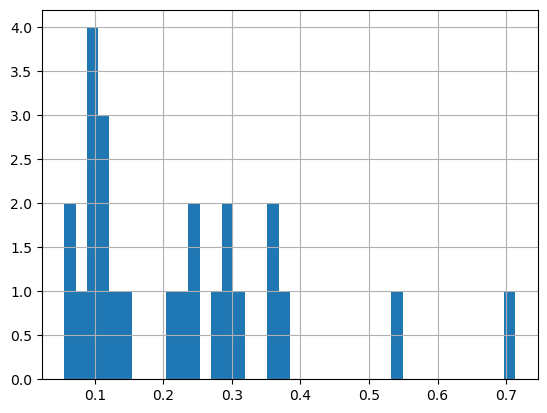

In [98]:
print('Range:', df_chla.matched_chla.min(), df_chla.matched_chla.max())
_ = df_chla.matched_chla.hist(bins=40)

### Plot a histogram of the SST data

Range: 14.86 25.6


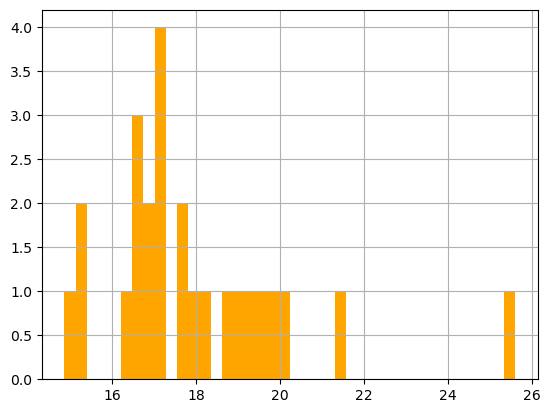

In [99]:
print('Range:', df_sst.matched_sst.min(), df_sst.matched_sst.max())
_ = df_sst.matched_sst.hist(bins=40,color='orange')

### Map the chlorophyll and SST data

In [ ]:
plt.figure(figsize=(14, 10))
#plot chl-a matchup
# Label axes of a Plate Carree projection with a central longitude of 180:
# set the projection
ax1 = plt.subplot(211, projection=ccrs.PlateCarree(central_longitude=180))

# Use the lon and lat ranges to set the extent of the map
# the 120, 260 lon range will show the whole Pacific
# the 15, 55 lat range with capture the range of the data
ax1.set_extent([120,255, 15, 55], ccrs.PlateCarree())

# set the tick marks to be slightly inside the map extents
ax1.set_xticks(range(120,255,20), crs=ccrs.PlateCarree())
ax1.set_yticks(range(20,50,10), crs=ccrs.PlateCarree())

# Add geographical features
ax1.add_feature(cfeature.LAND, facecolor='0.6')
ax1.coastlines()

# format the lat and lon axis labels
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax1.xaxis.set_major_formatter(lon_formatter)
ax1.yaxis.set_major_formatter(lat_formatter)

# build and plot coordinates onto map
x,y = list(df_chla.mean_lon),list(df_chla.mean_lat)
ax1 = plt.plot(x, y, transform=ccrs.PlateCarree(), color='lightgray',linestyle='dashed')
ax1 = plt.scatter(x, y, transform=ccrs.PlateCarree(),
                  marker='o',
                  c=np.log(df_chla.matched_chla),
                  cmap=plt.get_cmap('Greens')#BuGn')
                  )
ax1=plt.plot(x[0],y[0],marker='*', transform=ccrs.PlateCarree(), markersize=10)
ax1=plt.plot(x[-1],y[-1],marker='X', transform=ccrs.PlateCarree(), markersize=10)



# control color bar values spacing
levs2 = np.arange(-2.5, 0, 0.5)
cbar=plt.colorbar(ticks=levs2, shrink=0.75, aspect=10)
cbar.set_label("Chl a (mg/$m^3$)", size=15, labelpad=20)

# set the labels to be exp(levs2) so the label reflect values of chl-a, not log(chl-a)
cbar.ax.set_yticklabels(np.around(np.exp(levs2), 2), size=10)

plt.title("Chlorophyll Matchup to Animal Track #25317", size=15)

#plot sst matchup
# set the projection
ax2 = plt.subplot(212, projection=ccrs.PlateCarree(central_longitude=180))

# Use the lon and lat ranges to set the extent of the map
# the 120, 260 lon range will show the whole Pacific
# the 15, 55 lat range with capture the range of the data
ax2.set_extent([120,255, 15, 55], ccrs.PlateCarree())

# set the tick marks to be slightly inside the map extents
ax2.set_xticks(range(120,255,20), crs=ccrs.PlateCarree())
ax2.set_yticks(range(20,50,10), crs=ccrs.PlateCarree())

# Add geographical features
ax2.add_feature(cfeature.LAND, facecolor='0.6')
ax2.coastlines()

# format the lat and lon axis labels
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax2.xaxis.set_major_formatter(lon_formatter)
ax2.yaxis.set_major_formatter(lat_formatter)

# build and plot coordinates onto map
x,y = list(df_sst.mean_lon),list(df_sst.mean_lat)
ax2 = plt.plot(x, y, transform=ccrs.PlateCarree(), color='lightgray',linestyle='dashed')
ax2 = plt.scatter(x, y, transform=ccrs.PlateCarree(),
                  marker='o',
                  c=df_sst.matched_sst,
                  cmap=plt.get_cmap('hot_r')#OrRd')
                  )
ax2=plt.plot(x[0],y[0],marker='*', transform=ccrs.PlateCarree(), markersize=10)
ax2=plt.plot(x[-1],y[-1],marker='X', transform=ccrs.PlateCarree(), markersize=10)

# plot colorbar
cbar=plt.colorbar(shrink=0.75, aspect=10)
cbar.set_label("SST ($^o$C)", size=15, labelpad=20)

plt.title("Sea Surface Temperature Matchup to Animal Track #25317", size=15)

plt.tight_layout()
plt.show()

## On your own!

##### Exercise 1:
Repeat the steps above with a different dataset.
For example, use the weekly version of the OC-CCI dataset to see how cloud cover can reduce the data you retrieve. 
https://oceanwatch.pifsc.noaa.gov/erddap/griddap/esa-cci-chla-8d-v6-0.html
* This dataset is a different ERDDAP; It has the same base URL and variable name, but a different dataset ID.


##### Exercise 2:
Go to an ERDDAP of your choice, find a dataset of interest, generate the URL, copy it and edit the script above to run a match up on that dataset.
To find other ERDDAP servers, you can use this search engine:
http://erddap.com/  
* This dataset will likely be on a different base URL and dataset ID and variable name.
* Check the metadata to make sure the dataset covers the spatial and temporal range of the track dataset. 
